In [2]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [219]:
%matplotlib inline

from sessions import selected_008229
from imports import *
from scipy import stats
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from correlation import cluster_corr
from skimage.color import rgba2rgb
from matplotlib.gridspec import GridSpec
from sklearn import decomposition

#import cv2

In [220]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [216]:
def get_ratio_matrix(syll_tl, tl, win_l=2, step=1, s_rate=100, syl_num=10):
    idxs_srm_tl = np.arange(0, len(tl), int(step*s_rate))
    syl_ratio_mx = np.zeros([len(idxs_srm_tl), syl_num])
    for k, idx in enumerate(idxs_srm_tl):
        curr_syls = syll_tl[idx:idx + int(win_l*s_rate)]  # second column is syllables reindexed
        for j in np.arange(syl_num):
            syl_ratio_mx[k, j] = np.sum(curr_syls == j) / int(win_l*s_rate)

    # roll 1 step to match
    syl_ratio_mx = np.roll(syl_ratio_mx, 1, axis=0)
    syl_ratio_mx[0] = syl_ratio_mx[1]
    
    return syl_ratio_mx, idxs_srm_tl

In [217]:
def get_shuffled(syll_tl):
    # shuffle MoSeq syllables correctly, as episodes
    idxs_change = np.where(np.abs(np.diff(syll_tl)) > 0)[0]

    periods = []
    periods.append(np.array([0, idxs_change[0]+1]))

    for i in range(len(idxs_change)-1):
        periods.append(np.array([idxs_change[i]+1, idxs_change[i+1]+1]))

    periods.append(np.array([periods[-1][1], len(syll_tl)]))

    periods_shuf = np.array(periods, dtype=np.int32)
    np.random.shuffle(periods_shuf)

    shuffled = syll_tl[periods_shuf[0][0]:periods_shuf[0][1]]
    for i in range(len(periods_shuf) - 1):
        shuffled = np.concatenate([shuffled, syll_tl[periods_shuf[i+1][0]:periods_shuf[i+1][1]]])
        
    return shuffled

In [221]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#rep_path = '/home/sobolev/nevermind/Andrey/analysis/PPC/video'

selected = selected_008229
selected

['008229_hippoSIT_2022-05-16_20-36-44',
 '008229_hippoSIT_2022-05-17_21-44-43',
 '008229_hippoSIT_2022-05-18_14-36-18',
 '008229_hippoSIT_2022-05-20_15-54-39']

In [262]:
session = selected[2]

session = '009266_hippoSIT_2023-04-20_08-57-39'

In [263]:
win_l = 2  # sec
step = 1  # sec

animal = session.split('_')[0]

s_path     = os.path.join(source, animal, session)
meta_file  = os.path.join(s_path, 'meta.h5')
unit_file  = os.path.join(s_path, 'units.h5')
mose_file  = os.path.join(s_path, 'MoSeq.h5')
desc_file  = os.path.join(s_path, 'descendants.h5')

with h5py.File(mose_file, 'r') as f:
    moseq = np.array(f['moseq'])
    headers = list(f['moseq'].attrs['headers'])

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    events = np.array(f['processed']['sound_events'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    trials = np.array(f['processed']['trial_idxs'])

with h5py.File(desc_file, 'r') as f:
    speed = np.array(f['speed'])
    hd = np.array(f['hd'])
    # bugfix
    if len(hd) > len(tl):
        hd = hd[:len(tl)]
        
single_units, spike_times = {}, {}
with h5py.File(unit_file, 'r') as f:
    unit_names = [x for x in f]
with h5py.File(unit_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])
        
syl_ratio_mx, idxs_srm_tl = get_ratio_matrix(moseq[:, 1], tl, win_l=win_l, step=step)
#syl_ratio_mx = get_ratio_matrix_ev(moseq, events, win_l=win_l, step=step)
#idxs_srm_tl  = events[:, 2].astype(np.int32)

print('Loaded session %s' % session)

Loaded session 009266_hippoSIT_2023-04-20_08-57-39


In [264]:
idxs_target = np.where(tl[:, 6] == 2)[0]
idxs_backgr = np.where(tl[:, 6] == 1)[0]
idxs_noise  = np.where(tl[:, 6] ==-1)[0]
idxs_reward = trials[trials[:, 5] == 1][:, 1].astype(np.int32)

# min duration in target, sec
min_dur = 0
idxs_to_idx1 = np.where(np.diff(idxs_target) > 5)[0] + 1 # target starts
idxs_to_idx2 = np.where(np.diff(idxs_target) > 5)[0][1:] # target ends
idxs_to_idx  = np.where(idxs_to_idx2 - idxs_to_idx1[:-1] > min_dur * 100)[0]
idxs_tgt_start = idxs_target[:-1][idxs_to_idx1[idxs_to_idx]]

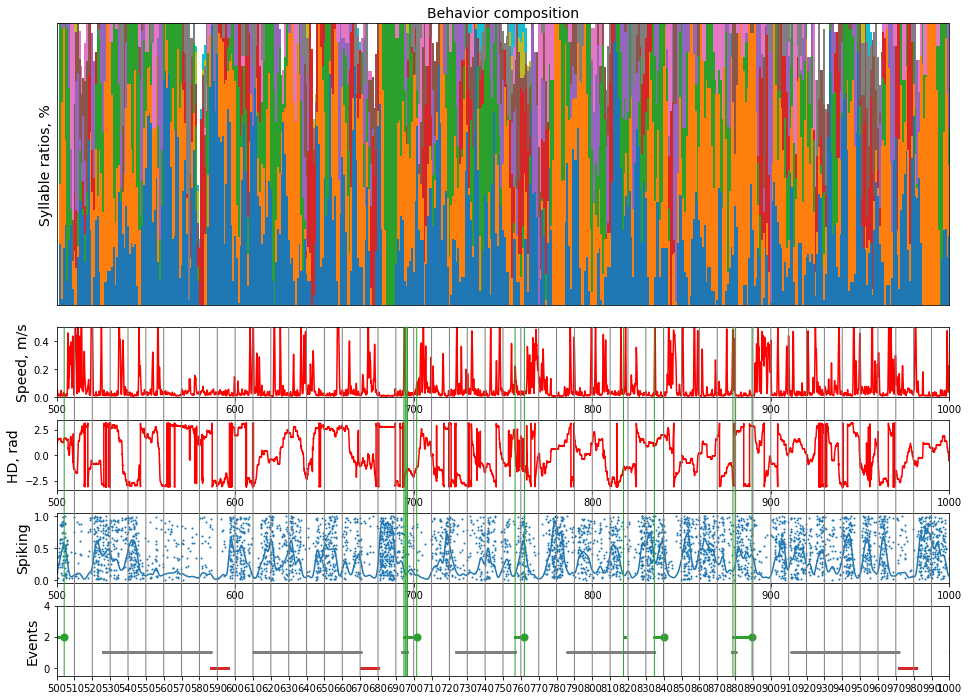

In [266]:
#sel_units = ['8-17']  # first session
#sel_units = ['8-8']
#sel_units = ['8-18']
sel_units = ['3-15']
t1, t2 = 500, 1000

colors_bold = [plt.cm.tab20(2*i) for i in range(10)]
colors_tran = [plt.cm.tab20(2*i + 1) for i in range(10)]
colors = colors_bold + colors_tran

#fig, axes = plt.subplots(2, 1, figsize=(16, 8))

fig = plt.figure(figsize=(16, 12))

gs = GridSpec(5, 1, height_ratios=[4, 1, 1, 1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])

# syllable ratios
idxs_to_idxs = np.where((tl[idxs_srm_tl][:, 0] > t1) & (tl[idxs_srm_tl][:, 0] < t2))[0]
idxs_sel = idxs_srm_tl[idxs_to_idxs]
bottom = np.zeros(len(idxs_sel))
for i, syl_ratio in enumerate(syl_ratio_mx[idxs_to_idxs].T):
    ax1.bar(tl[idxs_sel][:, 0] + step, syl_ratio, 1, bottom=bottom, label='Syll. # %s' % str(i+1))
    bottom += syl_ratio
ax1.set_xlim(t1, t2)
ax1.set_title('Behavior composition', fontsize=14)
ax1.set_ylabel('Syllable ratios, %', fontsize=14)
#ax.legend(loc='upper right')
ax1.set_xticks([])
ax1.set_yticks([])

# speed
ax2.plot(tl[:, 0], speed, color='red')
ax2.set_xlim(t1, t2)
ax2.set_ylabel('Speed, m/s', fontsize=14)
ax2.set_ylim(0, 0.5)

# HD
ax3.plot(tl[:, 0], hd, color='red')
ax3.set_xlim(t1, t2)
ax3.set_ylabel('HD, rad', fontsize=14)
#ax3.set_ylim(0, 0.5)

for i, unit_name in enumerate(sel_units):
    s_times = spike_times[unit_name]
    i_rate  = single_units[unit_name]
    #i_rate = instantaneous_rate(s_times, tl[:, 0], k_width=30)  # make it more crispy if needed
    values = np.random.rand(len(s_times))
    speed_corr = stats.pearsonr(i_rate, speed)[0]

    ax4.scatter(s_times, values, s=1)
    ax4.plot(tl[:, 0], i_rate/i_rate.max())
    ax4.set_xlim(t1, t2)
    ax4.set_ylabel('Spiking', fontsize=14)
    #ax4.set_title("Speed corr: %.2f" % speed_corr, fontsize=14)

# events
x_ticks = np.arange(0, 2400, 10)
ax5.scatter(tl[idxs_target][:, 0], 2*np.ones(len(idxs_target)), s=1, color=COLORS[2])
ax5.scatter(tl[idxs_backgr][:, 0], 1*np.ones(len(idxs_backgr)), s=1, color=COLORS[4])
ax5.scatter(tl[idxs_noise][:, 0],  0*np.zeros(len(idxs_noise)),  s=1, color=COLORS[3])
ax5.scatter(tl[idxs_reward][:, 0], 2*np.ones(len(idxs_reward)), s=50, color=COLORS[2])
ax5.set_xticks(np.arange(0, 2400, 10))
ax5.set_xlim(t1, t2)
ax5.set_ylim(-0.5, 4)
ax5.set_ylabel('Events', fontsize=14)

to_plot = [idxs_tgt_start, idxs_reward, 100*x_ticks[(x_ticks > t1) & (x_ticks < t2)]]
colors = [COLORS[2], COLORS[2], COLORS[4], COLORS[2]]

for j, idxs_var in enumerate(to_plot):
    xy1 = np.vstack([ tl[idxs_var][:, 0],  0.5 * np.ones(len(idxs_var)) ]).T
    xy3 = np.vstack([ tl[idxs_var][:, 0], -0.5 * np.ones(len(idxs_var)) ]).T
    for i in range(len(idxs_var)):
        if xy1[i][0] < t1 or xy1[i][0] > t2:
            continue
        con = ConnectionPatch(xyA=xy1[i], coordsA=ax2.transData, xyB=xy3[i], coordsB=ax5.transData, color=colors[j])
        fig.add_artist(con)
#fig.tight_layout()
#fig.savefig(os.path.join(report, 'TL_%s_%s_%s.png' % (t1, t2, session)))

## Head direction

(-3.141592653589793, 3.141592653589793)

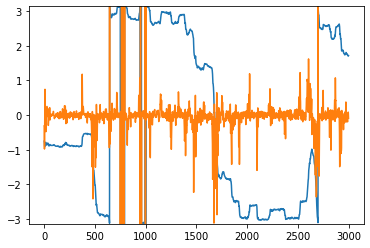

In [247]:
xl, xr = 1940, 1980
xl, xr = 2020, 2060
xl, xr =  520, 550

fig, ax = plt.subplots(1, 1)
ax.plot(hd[xl*100:xr*100])
ax.plot(20*np.gradient(hd[xl*100:xr*100]))
ax.set_ylim(-np.pi, np.pi)

In [248]:
# correction for absolute angle
threshold = np.pi/2
to_add = np.zeros(len(hd))
for i in range(len(hd) - 1):
    if hd[i] > threshold and hd[i+1] < -threshold:  # increase
        to_add[i+1] = to_add[i] + 1
    elif hd[i] < -threshold and hd[i+1] > threshold:  # decrease
        to_add[i+1] = to_add[i] - 1
    else:
        to_add[i+1] = to_add[i]

hd_corr = hd + 2*np.pi*to_add

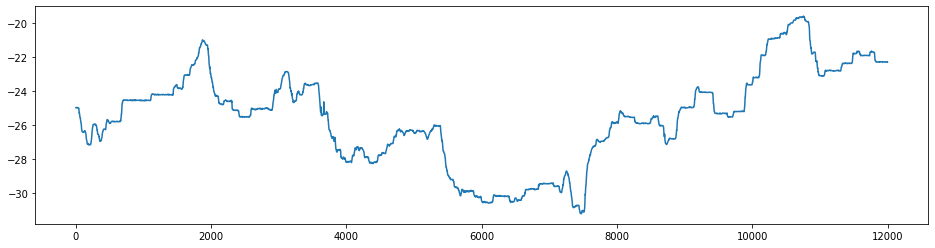

In [267]:
#xl, xr = 1940, 1980
#xl, xr = 2020, 2060
#xl, xr = 560, 610
#xl, xr =  520, 550
xl, xr =  770, 890

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
#ax.plot(hd[:30000])
#ax.plot(to_add[:30000])
ax.plot(hd_corr[xl*100:xr*100])

(-0.3, 0.3)

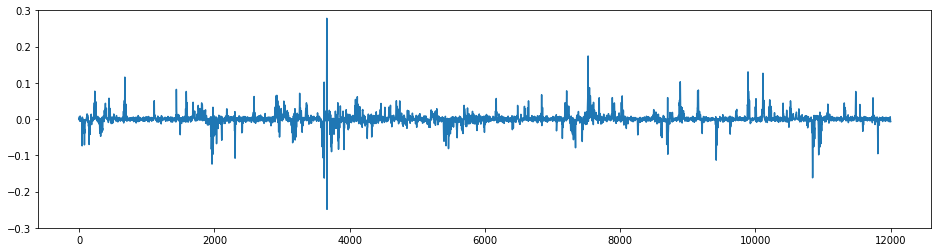

In [268]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(np.gradient(hd_corr[xl*100:xr*100]))
ax.set_ylim(-0.3, 0.3)

## PCA on syllable ratio matrix - calibrating window size

In [251]:
# window sizes
#win_sizes = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
win_sizes = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
#win_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
syll_tl = moseq[:, 1]
step = 1
syl_num = 15
shuf_num = 5

var_real = np.zeros([len(win_sizes), syl_num])
var_shuf = np.zeros([len(win_sizes), syl_num])

for i, win_size in enumerate(win_sizes):
    # PCA on real behavior
    syl_ratio_mx, idxs_srm_tl = get_ratio_matrix(syll_tl, tl, win_l=win_size, step=step, syl_num=syl_num)
    pca = decomposition.PCA(n_components=syl_num)
    X = pca.fit_transform(syl_ratio_mx)
    var_real[i] = pca.explained_variance_ratio_
    
    # PCA on shuffled behavior
    var_shuf_curr = np.zeros([shuf_num, syl_num])
    for j in range(shuf_num):
        syll_tl_shuf = get_shuffled(syll_tl)
        syl_ratio_mx, _ = get_ratio_matrix(syll_tl_shuf, tl, win_l=win_size, step=step, syl_num=syl_num)
        pca_shuf = decomposition.PCA(n_components=syl_num)
        X = pca_shuf.fit_transform(syl_ratio_mx)
        var_shuf_curr[j] = pca_shuf.explained_variance_ratio_
        
    var_shuf[i] = var_shuf_curr.mean(axis=0)
    print(win_size, end=', ')

2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 

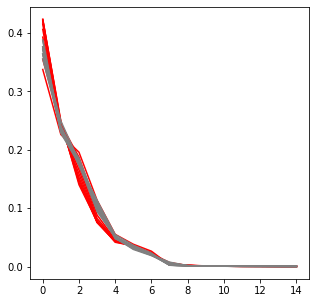

In [252]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for var in var_real:
    ax.plot(var, color='red')
for var in var_shuf:
    ax.plot(var, color='grey')

In [235]:
var_real[:, 0]

array([0.2586479 , 0.28467407, 0.30115534, 0.32119912, 0.33894319,
       0.35832441, 0.37370995, 0.39002869, 0.4025963 , 0.41631915])

In [149]:
idxs_AL = np.where(single_units[unit_name][idxs_srm_tl] > 5)[0]
idxs_PH = np.where(single_units[unit_name][idxs_srm_tl] < 5)[0]

len(idxs_AL), len(idxs_PH)

(1489, 911)

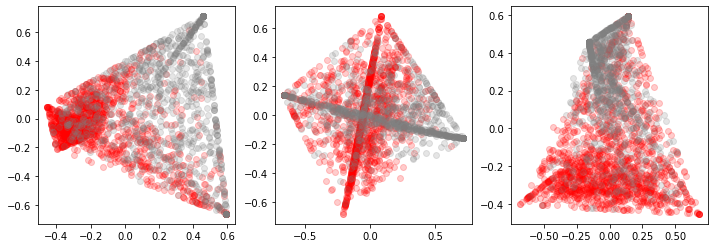

In [151]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].scatter(X[:, 0][idxs_AL], X[:, 1][idxs_AL], alpha=0.2, color='red')
axes[0].scatter(X[:, 0][idxs_PH], X[:, 1][idxs_PH], alpha=0.2, color='grey')
axes[1].scatter(X[:, 1][idxs_AL], X[:, 2][idxs_AL], alpha=0.2, color='red')
axes[1].scatter(X[:, 1][idxs_PH], X[:, 2][idxs_PH], alpha=0.2, color='grey')
axes[2].scatter(X[:, 2][idxs_AL], X[:, 0][idxs_AL], alpha=0.2, color='red')
axes[2].scatter(X[:, 2][idxs_PH], X[:, 0][idxs_PH], alpha=0.2, color='grey')

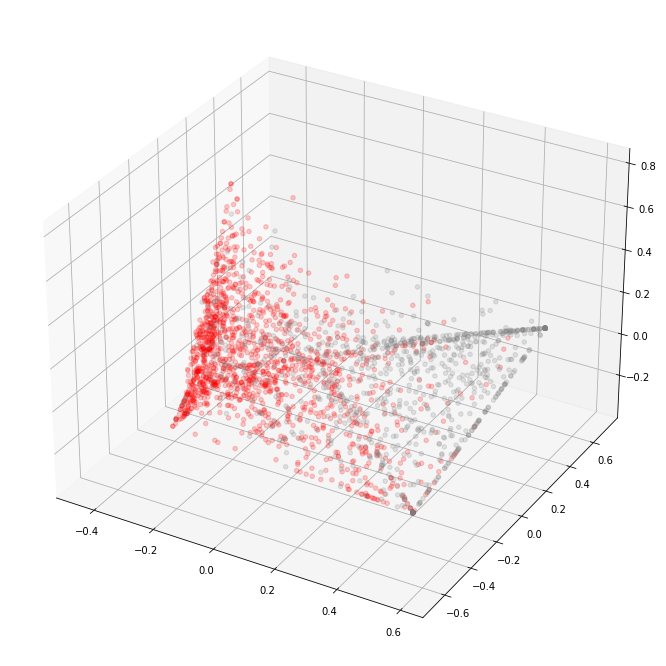

In [153]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:, 0][idxs_AL], X[:, 1][idxs_AL], X[:, 3][idxs_AL], alpha=0.2, color='red')
ax.scatter(X[:, 0][idxs_PH], X[:, 1][idxs_PH], X[:, 3][idxs_PH], alpha=0.2, color='grey')

In [140]:
idxs_srm_tl

(2400,)

(array([48686., 14971., 11206., 10735.,  9844., 13066., 14762., 17593.,
        20911., 18973., 16429., 14474., 11414.,  7801.,  3658.,  2525.,
         1680.,   722.,   262.,   287.]),
 array([ 0.        ,  1.10548752,  2.21097504,  3.31646256,  4.42195008,
         5.5274376 ,  6.63292512,  7.73841264,  8.84390016,  9.94938767,
        11.05487519, 12.16036271, 13.26585023, 14.37133775, 15.47682527,
        16.58231279, 17.68780031, 18.79328783, 19.89877535, 21.00426287,
        22.10975039]),
 <BarContainer object of 20 artists>)

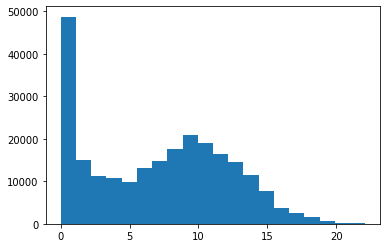

In [143]:
plt.hist(single_units[unit_name], bins=20)